In [1]:
import emoji
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
emoji_dict = emoji.EMOJI_UNICODE

In [3]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":beaming_face_with_smiling_eyes:",
                    "3": ":downcast_face_with_sweat:",
                    "4": ":fork_and_knife:",
                   }

In [4]:
for emo in emoji_dictionary.values():
    print(emoji.emojize(emo))

❤️
⚾
😁
😓
🍴


In [5]:
Training_data = pd.read_csv("Dataset/train_emoji.csv",header=None)
Testing_data = pd.read_csv("Dataset/test_emoji.csv",header=None)

In [6]:
Testing_data.head()

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


In [7]:
X_train,y_train  = Training_data.iloc[:,0].values,Training_data.iloc[:,1].values
X_test,y_test = Testing_data.iloc[:,0].values,Testing_data.iloc[:,1].values

In [8]:
for i in range(5):
    print(X_train[i],"--->",emoji.emojize(emoji_dictionary[str(y_train[i])]))

never talk to me again ---> 😓
I am proud of your achievements ---> 😁
It is the worst day in my life ---> 😓
Miss you so much ---> ❤️
food is life ---> 🍴


In [9]:
embeddings_index={}
with open("glove.6B.50d.txt",encoding='utf-8') as f:
    for line in f:
        value = line.split(" ")
        word = value[0]
        coef = np.asarray(value[1:],dtype = 'float32')
        embeddings_index[word] = list(coef)

In [10]:
def embedding_output(X):
    maxLen = 10
    emb_dim = 50
    embedding_out = np.zeros((X.shape[0],maxLen,emb_dim))
    
    for ix in range(X.shape[0]):
        X[ix] = X[ix].split()
        for ij in range(len(X[ix])):
            try:
                embedding_out[ix][ij] = embeddings_index[X[ix][ij].lower()]
            except:
                embedding_out[ix][ij] = np.zeros((emb_dim,))
    return embedding_out

In [11]:
embedding_matrix_train = embedding_output(X_train)
embedding_matrix_test = embedding_output(X_test)
y_train = to_categorical(y_train,num_classes=5)
y_test = to_categorical(y_test,num_classes=5)

In [12]:
model = Sequential()
model.add(LSTM(64,input_shape = (10,50),return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            29440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 62,789
Trainable params: 62,789
Non-trainable params: 0
__________________________________________________

In [13]:
checkpoint = ModelCheckpoint("best_emoji_model.h5",monitor = 'val_loss',verbose=False,save_best_only= True)
earlyStop = EarlyStopping(monitor='val_loss',patience = 10)
history = model.fit(embedding_matrix_train,y_train,epochs=100,batch_size=64,shuffle=True,validation_split=0.1,callbacks=[checkpoint,earlyStop])

Train on 118 samples, validate on 14 samples
Epoch 1/100
118/118 [==============================] - 4s 30ms/step - loss: 1.6127 - accuracy: 0.1695 - val_loss: 1.6038 - val_accuracy: 0.5000
Epoch 2/100
118/118 [==============================] - 0s 669us/step - loss: 1.6081 - accuracy: 0.2288 - val_loss: 1.5982 - val_accuracy: 0.3571
Epoch 3/100
118/118 [==============================] - 0s 653us/step - loss: 1.5556 - accuracy: 0.3475 - val_loss: 1.5969 - val_accuracy: 0.3571
Epoch 4/100
118/118 [==============================] - 0s 1ms/step - loss: 1.5327 - accuracy: 0.3220 - val_loss: 1.6046 - val_accuracy: 0.3571
Epoch 5/100
118/118 [==============================] - 0s 1ms/step - loss: 1.5119 - accuracy: 0.3390 - val_loss: 1.6158 - val_accuracy: 0.3571
Epoch 6/100
118/118 [==============================] - 0s 1ms/step - loss: 1.4817 - accuracy: 0.4322 - val_loss: 1.6315 - val_accuracy: 0.3571
Epoch 7/100
118/118 [==============================] - 0s 1ms/step - loss: 1.4601 - accuracy

In [14]:
y_pred = model.predict(embedding_matrix_test)

In [15]:
loss,test_acc = model.evaluate(embedding_matrix_test,y_test)

print(test_acc*100)

56/56 [==============================] - 0s 270us/step
62.5


In [16]:
model.load_weights("best_emoji_model.h5")

In [17]:
loss,test_acc = model.evaluate(embedding_matrix_test,y_test)

print(test_acc*100)

56/56 [==============================] - 0s 341us/step
60.71428656578064


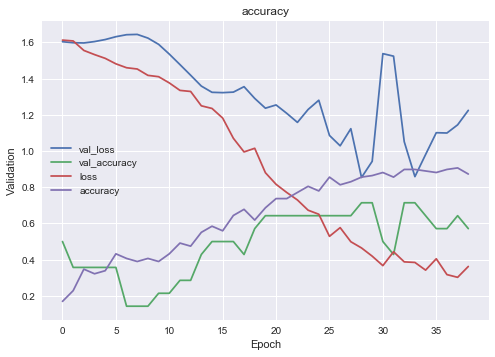

In [18]:
for key,values in (history.history).items():
    plt.plot(values,label = key)
    plt.xlabel("Epoch")
    plt.ylabel("Validation")
    plt.legend()
    plt.title(key)

In [19]:
for i in range(30):
    print(" ".join(X_test[i]))
    print("Actual Emoji : ",emoji.emojize(emoji_dictionary[str(np.argmax(y_test[i]))]))
    print("Predicted Emoji : ",emoji.emojize(emoji_dictionary[str(np.argmax(y_test[i]))]))
    print()

I want to eat
Actual Emoji :  🍴
Predicted Emoji :  🍴

he did not answer
Actual Emoji :  😓
Predicted Emoji :  😓

he got a raise
Actual Emoji :  😁
Predicted Emoji :  😁

she got me a present
Actual Emoji :  ❤️
Predicted Emoji :  ❤️

ha ha ha it was so funny
Actual Emoji :  😁
Predicted Emoji :  😁

he is a good friend
Actual Emoji :  ❤️
Predicted Emoji :  ❤️

I am upset
Actual Emoji :  ❤️
Predicted Emoji :  ❤️

We had such a lovely dinner tonight
Actual Emoji :  ❤️
Predicted Emoji :  ❤️

where is the food
Actual Emoji :  🍴
Predicted Emoji :  🍴

Stop making this joke ha ha ha
Actual Emoji :  😁
Predicted Emoji :  😁

where is the ball
Actual Emoji :  ⚾
Predicted Emoji :  ⚾

work is hard
Actual Emoji :  😓
Predicted Emoji :  😓

This girl is messing with me
Actual Emoji :  😓
Predicted Emoji :  😓

are you serious ha ha
Actual Emoji :  😁
Predicted Emoji :  😁

Let us go play baseball
Actual Emoji :  ⚾
Predicted Emoji :  ⚾

This stupid grader is not working
Actual Emoji :  😓
Predicted Emoji :  😓

wor

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
y_test = np.argmax(y_test,axis=1)
y_pred = np.argmax(y_pred,axis=1)

In [24]:
confMat = confusion_matrix(y_test,y_pred)

In [25]:
confMat

array([[ 5,  0,  6,  1,  0],
       [ 0,  5,  0,  0,  0],
       [ 3,  1, 12,  2,  0],
       [ 2,  0,  3,  9,  1],
       [ 0,  0,  1,  1,  4]], dtype=int64)